# I80 Environment for CIVENG 299 Individual Research

In [1]:
from __future__ import annotations

import math
import os
import sys
from functools import lru_cache
from typing import Any, Dict, List, Optional, Tuple, Union

import numpy as np
import torch as th
from matplotlib import pyplot as plt
from gymnasium.core import Env, ObsType, ActType
from gymnasium.spaces import Box, Space

# SUMO Traci
if 'SUMO_HOME' in os.environ:
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
    import sumolib
    import traci
else:
    sys.exit('Please declare envrionment variable "SUMO_HOME".')

PathLike = Union[str, 'os.PathLike[str]']
ASSET_DIR = '../simulation/i80/assets/'

In [2]:
# OpenAI Gym API environment for Reinforcement Learning
#
# @Parameters:
#
# Key Arguments:
#   pr: penetration rate of autonomous vehicles
#   step_interval: a float number of seconds between actions

class CVI80Env(Env):
    """I80 Emeryville connected vehicle variable speed limit environment.

    This environment is associated with the variable speed limit control
    problem on Interstate I80, Emeryville, CA. Scenario is generated using
    NGSIM I80 Emeryville Dataset.

    - Action Space

        The action is a float array of shape `(1, )` with elements in range
        `[15.64, 29.06]`, corresponding to 35~65 mph.

    - Observation Space

        The observation is a 

    - Rewards

    - Starting State

        The starting state is captured after warming up for 300 seconds.
    
    - Episode Termination

        The episode terminates after 3600 simulation seconds.

    - Arguments
    """
    metadata: Dict[str, Any] = {'render_modes': ['human']}
    
    def __init__(self,
                 penetration_rate: float = 0.0,
                 exp_name: str = 'default',
                 raster_length: float = 20.0,
                 gui: bool = False,
                 step_interval: float = 5.0) -> None:
        super().__init__()

        self.exp_name = exp_name
        self.step_interval: float = step_interval
        self.sumo_binary: str = 'sumo-gui' if gui else 'sumo'
        self.sumo_cfg = os.path.join(ASSET_DIR, 'i80.sumo.cfg')
        # TODO: route file corresponding to different pr
        assert penetration_rate in [0.0, 0.02, 0.05, 0.10], ValueError(
            'Expect CV penetration rate to be 0%, 2%, 5%, or 10%, '
            f'but got {penetration_rate * 100}%.'
        )
        if penetration_rate == 0.0:
            self.route_file = os.path.join(ASSET_DIR, 'i80_pr_0.rou.xml')
        if penetration_rate == 0.02:
            self.route_file = os.path.join(ASSET_DIR, 'i80_pr_2.rou.xml')
        if penetration_rate == 0.05:
            self.route_file = os.path.join(ASSET_DIR, 'i80_pr_5.rou.xml')
        if penetration_rate == 0.10:
            self.route_file = os.path.join(ASSET_DIR, 'i80_pr_10.rou.xml')

        # Observation parameters
        self.raster_length = raster_length
        self._net = sumolib.net.readNet(os.path.join(ASSET_DIR, 'i80.net.xml'))
        self._obs_edges = [
            # Mainline edges
            'i80_load_n',
            'i80_upstream_n',
            'i80_weaving_n',
            'i80_weaving_ext_n',
            'i80_shrink_n',
            # Ramps
            'powell_on_ramp',
            'ashby_off_ramp'
        ]
        self._edge_left_grid_map = {}
        self._edge_right_grid_map = {}
        _grid = 0
        for edge_id in self._obs_edges:
            edge = self._net.getEdge(edge_id)
            if 'i80' in edge_id:
                self._edge_left_grid_map[edge_id] = _grid
                _grid += math.ceil(edge.getLength() / self.raster_length)
                self._edge_right_grid_map[edge_id] = _grid
            if edge_id == 'powell_on_ramp':
                self._edge_left_grid_map[edge_id] = \
                    self._edge_left_grid_map['i80_weaving_n'] - \
                    math.ceil(edge.getLength() / self.raster_length)
                self._edge_right_grid_map[edge_id] = \
                    self._edge_left_grid_map['i80_weaving_n']
            if edge_id == 'ashby_off_ramp':
                self._edge_left_grid_map[edge_id] = \
                    self._edge_right_grid_map['i80_weaving_ext_n']
                self._edge_right_grid_map[edge_id] = \
                    self._edge_right_grid_map['i80_weaving_ext_n'] + \
                    math.ceil(edge.getLength() / self.raster_length)
        self.obs_width = max(self._edge_right_grid_map.values())
        self.obs_height = max(
            self._net.getEdge(edge_id).getLaneNumber()
            for edge_id in self._obs_edges if 'i80' in edge_id
        ) + 1
        self.observation_space = Box(
            low=0.0, high=float('inf'),
            shape=(2, self.obs_height, self.obs_width)
        )
        
        # Action and Reward parameters
        self.action_space = Box(low=15.64, high=29.06, shape=(1, ))


    def reset(self,
              *,
              seed: Optional[int] = None,
              options: Optional[Dict] = None) -> Tuple[ObsType, Dict]:
        # TODO: Reset the sumo simulation environment
        super().reset(seed=seed, options=options)

        if seed is not None:
            sumo_cmd = [
                self.sumo_binary,
                '-c', self.sumo_cfg, 
                '--route-files', self.route_file,
                '--start',
                '--seed', str(seed),
                '--quit-on-end'
            ]
        else:
            sumo_cmd = [
                self.sumo_binary,
                '-c', self.sumo_cfg,
                '--route-files', self.route_file,
                '--start',
                '--quit-on-end'
            ]

        traci.start(sumo_cmd, label=self.exp_name)
        self.scenario = traci.getConnection(self.exp_name)
        self.warm_up()

        curr_time = traci.simulation.getTime()
        obs, t_feat = [], []
        for time in range(math.floor(self.step_interval)):
            while traci.simulation.getTime() < curr_time + 1.0:
                traci.simulationStep()
            
            curr_obs = self.get_observation()
            obs.append(curr_obs)
            t_feat.append(np.ones_like(curr_obs) * time)
            curr_time += 1.0

        obs = np.concatenate(obs, axis=0)
        t_feat = np.concatenate(t_feat, axis=0)
        obs = np.stack([obs, t_feat])

        return obs, {}
        

    def step(self, action: ActType) -> Tuple[ObsType, float, bool, bool, Dict]:
        """Take action to apply speed limit to all the connected vehicles."""
        assert action.shape == self.action_space.shape, ValueError(
            f'Incosistent action shape, expect {self.action_space.shape}, '
            f'but got {action.shape}.'
        )

        self.take_action(action)
        curr_time = traci.simulation.getTime()
        obs, t_feat = [], []
        reward: float = 0.0
        for time in range(math.floor(self.step_interval)):
            while traci.simulation.getTime() < curr_time + 1.0:
                traci.simulationStep()
            
            curr_obs = self.get_observation()
            obs.append(curr_obs)
            t_feat.append(np.ones_like(curr_obs) * time)
            reward += self.get_reward()
            curr_time += 1.0

        obs = np.concatenate(obs, axis=0)
        t_feat = np.concatenate(t_feat, axis=0)
        obs = np.stack([obs, t_feat])
        terminated = traci.simulation.getTime() >= 3900

        return obs, reward, terminated, False, {}

    def close(self):
        """Close connection to current sumo environment."""
        traci.close()

    def get_observation(self) -> np.ndarray:
        obs = np.zeros([self.obs_height, self.obs_width], 'float32')
        for edge_id in self._obs_edges:
            edge = self._net.getEdge(edge_id)
            edge_len = edge.getLength()
            num_lanes = edge.getLaneNumber()
            _left = self._edge_left_grid_map[edge_id]
            _right = self._edge_right_grid_map[edge_id]

            for idx in range(num_lanes):
                row_obs = np.zeros([1, _right - _left], 'float32')
                lane_id = '_'.join([edge_id, str(idx)])
                veh_ids = traci.lane.getLastStepVehicleIDs(lane_id)
                veh_pos = list(
                    map(
                        lambda x, eid=edge_id, elen=edge_len:
                        traci.vehicle.getDrivingDistance(x, eid, elen),
                        veh_ids
                    )
                )
                for v_id, v_pos in zip(veh_ids, veh_pos):
                    veh_len = traci.vehicle.getLength(v_id)
                    rear_grid = math.floor(v_pos / self.raster_length)
                    front_grid = math.ceil(v_pos / self.raster_length)
                    if rear_grid + 1 == front_grid:
                        row_obs[0, rear_grid] += 1
                    if rear_grid + 2 == front_grid:
                        ref = self.raster_length * (rear_grid + 1)
                        if rear_grid >= 0:
                            row_obs[0, rear_grid] = \
                                (ref - v_pos + veh_len / 2) / veh_len
                        if rear_grid + 1 <= _right:
                            row_obs[0, rear_grid + 1] = \
                                (v_pos + veh_len / 2 - ref) / veh_len

                obs[idx, _left:_right] = row_obs

        return obs

    def get_reward(self) -> float:
        # Harmonization: Minimize variation of mainline vehicles' speed
        var_reward = -np.var(
            [traci.vehicle.getSpeed(v) for v in self.mainline_vehicles]
        )

        # Efficiency: Minimize average waiting time of all vehicles
        wt_reward = -np.mean(
            [traci.vehicle.getTimeLoss(v) for v in self.vehicles]
        )

        return 0.6 * var_reward + 0.4 * wt_reward

    def take_action(self, action: ActType) -> None:
        for vehicle in self.vehicles:
            if 'cv' in vehicle:
                traci.vehicle.setMaxSpeed(action[0])

    def warm_up(self) -> None:
        """Warm up simulation before getting the starting state."""
        while traci.simulation.getTime() <= \
            300 - math.floor(self.step_interval):
            traci.simulationStep()

    @property
    def mainline_vehicles(self) -> List[str]:
        ml_veh_ids = []
        for edge_id in self._obs_edges:
            if not 'i80' in edge_id:
                continue

            edge = self._net.getEdge(edge_id)
            for lane in edge.getLanes():
                ml_veh_ids += traci.lane.getLastStepVehicleIDs(lane.getID())
        
        return ml_veh_ids

    @property
    def vehicles(self) -> List[str]:
        veh_ids = []
        for edge_id in self._obs_edges:
            edge = self._net.getEdge(edge_id)
            for lane in edge.getLanes():
                veh_ids += traci.lane.getLastStepVehicleIDs(lane.getID())
        
        return veh_ids

In [3]:
env = CVI80Env(gui=True)
obs, _ = env.reset(seed=42)

 Retrying in 1 seconds


Fontconfig warning: ignoring UTF-8: not a valid region tag


In [4]:
done = False
while not done:
    next_obs, rew, done, _, _ = env.step(env.action_space.sample())
    obs = next_obs


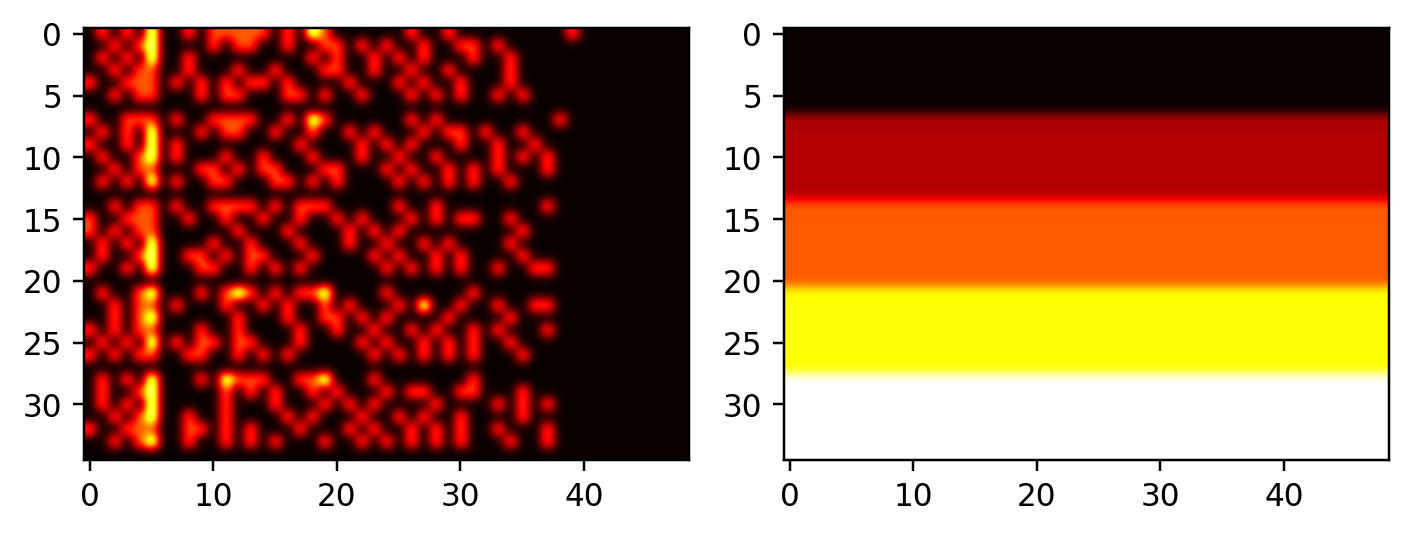

In [5]:
fig, axes = plt.subplots(1, obs.shape[0], dpi=224)
for i, ax in enumerate(axes):
    ax.imshow(obs[i], cmap='hot', interpolation='gaussian')
    ax.set_yticks(np.arange(0, env.obs_height * int(env.step_interval), 5))

fig.tight_layout()

In [6]:
env.close()